#### Imports necessários

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

#### Carregamento dos dados

In [16]:
df = pd.read_csv("desafio_indicium_imdb.csv", sep=',')
df = df.drop(df.columns[0], axis=1)
df.tail()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
994,Breakfast at Tiffany's,1961,A,115 min,"Comedy, Drama, Romance",7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,NaN
995,Giant,1956,G,201 min,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN
996,From Here to Eternity,1953,Passed,118 min,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,"30,500,000"
997,Lifeboat,1944,NaN,97 min,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN
998,The 39 Steps,1935,NaN,86 min,"Crime, Mystery, Thriller",7.6,A man in London tries to help a counter-espion...,93.0,Alfred Hitchcock,Robert Donat,Madeleine Carroll,Lucie Mannheim,Godfrey Tearle,51853,NaN


#### Tratamento dos tipos de cada coluna

In [ ]:
df = df.dropna()
df.Gross = df.Gross.str.replace(",", "", regex=False).astype(int)
df.Released_Year = df.Released_Year.astype(int)
df.IMDB_Rating = df.IMDB_Rating.astype(float)
df.Meta_score = df.Meta_score.astype(float)
df.Runtime = df.Runtime.str.replace(" min", "", regex=False).astype(int)

df.Genre = df.Genre.str.split(',')
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df.Genre),
							 columns=mlb.classes_,
							 index=df.index)
df = pd.concat([df, genre_encoded], axis=1)
df.drop("Genre", axis=1, inplace=True)

df.head()

,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,...,Animation,Biography,Comedy,Crime,Drama,Family,Film-Noir,Horror,Mystery,Western
0,The Godfather,1972,A,175,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,...,0,0,0,1,0,0,0,0,0,0
1,The Dark Knight,2008,UA,152,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,...,0,0,0,0,0,0,0,0,0,0
2,The Godfather: Part II,1974,A,202,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,...,0,0,0,1,0,0,0,0,0,0
3,12 Angry Men,1957,U,96,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,...,0,0,0,1,0,0,0,0,0,0
4,The Lord of the Rings: The Return of the King,2003,U,201,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,...,0,0,0,0,0,0,0,0,0,0


In [27]:
set1 = set(df.Star1.unique())
set2 = set(df.Star2.unique())

len(set1.intersection(set2)), len(set1), len(set2)

(134, 471, 598)

In [84]:
df.No_of_Votes.describe()

count    7.130000e+02
mean     3.533480e+05
std      3.462212e+05
min      2.522900e+04
25%      9.582600e+04
50%      2.363110e+05
75%      5.059180e+05
max      2.303232e+06
Name: No_of_Votes, dtype: float64

In [16]:
#df.Gross = df.Gross.str.replace(",", "", regex=False).astype(int)
df.Gross.describe(include=all)
#df.loc[df.Gross.idxmax()]

count    7.130000e+02
mean     7.858395e+07
std      1.150433e+08
min      1.305000e+03
25%      6.153939e+06
50%      3.500000e+07
75%      1.025158e+08
max      9.366622e+08
Name: Gross, dtype: float64

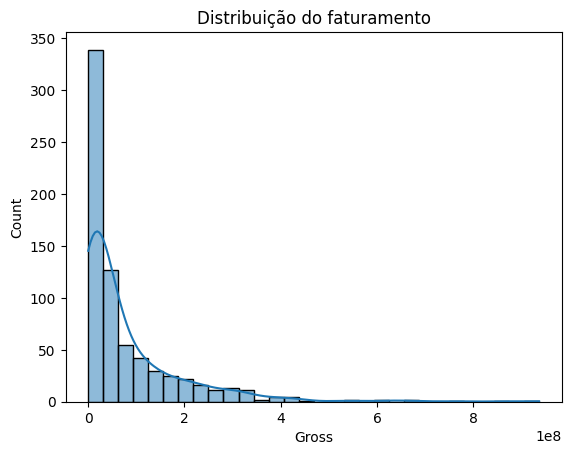

In [27]:
# Distribuição de idades
sns.histplot(df.Gross, bins=30, kde=True)
plt.title("Distribuição do faturamento")
plt.show()

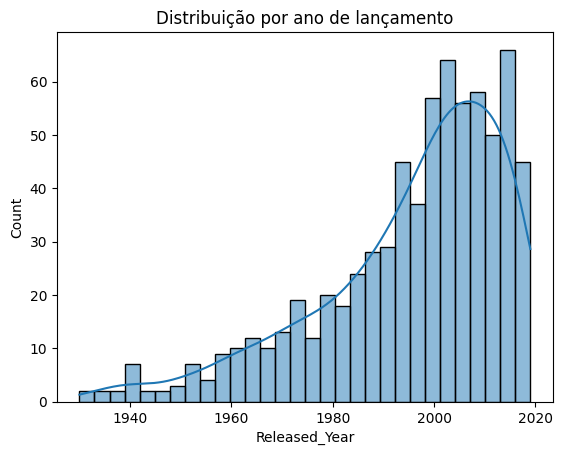

In [65]:
sns.histplot(df.Released_Year, bins=30, kde=True)
plt.title("Distribuição por ano de lançamento")
plt.show()

In [70]:
print("\nValores nulos por coluna:\n")
print(df.isnull().sum())


Valores nulos por coluna:

Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64


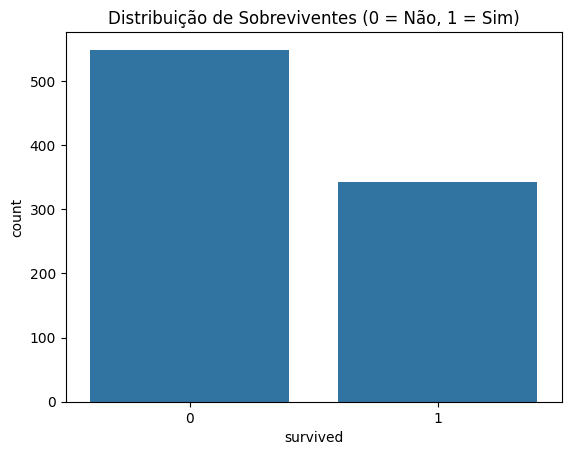

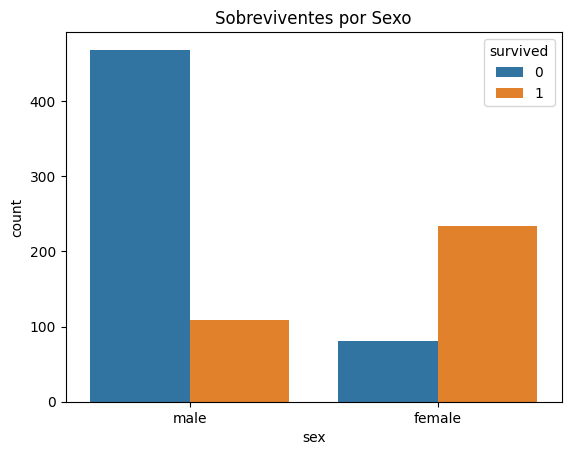

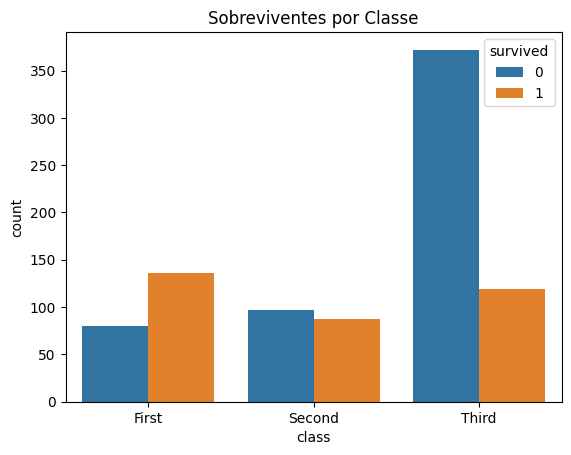

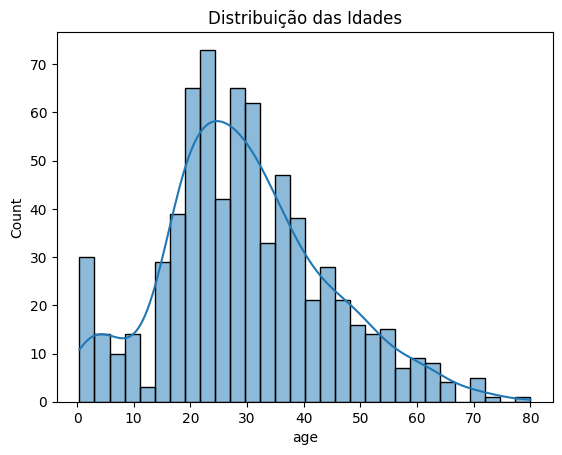

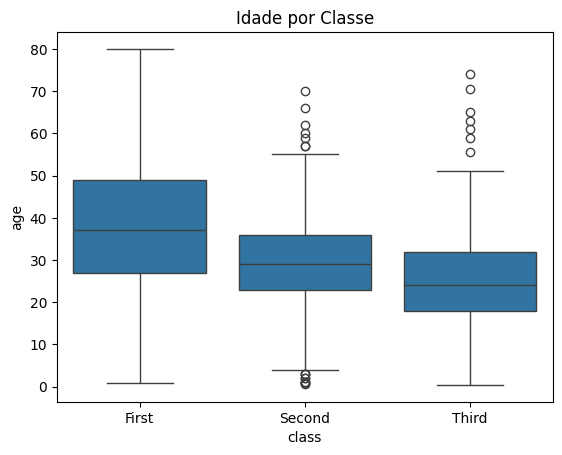

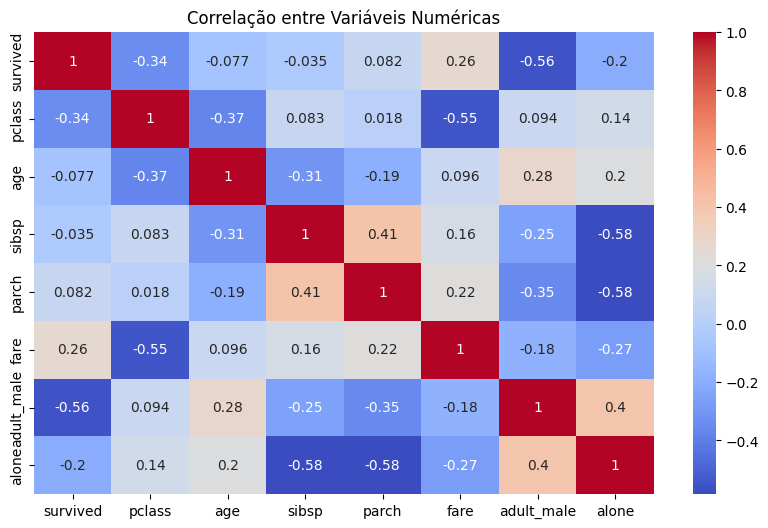

In [6]:
sns.countplot(x="survived", data=df)
plt.title("Distribuição de Sobreviventes (0 = Não, 1 = Sim)")
plt.show()

sns.countplot(x="sex", hue="survived", data=df)
plt.title("Sobreviventes por Sexo")
plt.show()


# Sobreviventes por classe
sns.countplot(x="class", hue="survived", data=df)
plt.title("Sobreviventes por Classe")
plt.show()

# Distribuição de idades
sns.histplot(df["age"].dropna(), bins=30, kde=True)
plt.title("Distribuição das Idades")
plt.show()

# Boxplot de idade por classe
sns.boxplot(x="class", y="age", data=df)
plt.title("Idade por Classe")
plt.show()

# Correlação entre variáveis numéricas
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlação entre Variáveis Numéricas")
plt.show()